In [1]:
import sklearn.cluster as clt
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
import seaborn as sb
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as olors
from sklearn.decomposition import PCA
import plotly.express as px

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
import random
random.seed(1234)

## **1.-Loading the clusters**

We first load the previously created embeddings

In [2]:
DB = pd.read_csv("../data/processed/predictionDB.csv",lineterminator='\n')

embeddings = []
i = 0
for np_name in glob.glob('./../data/processed/embeddings/*.np[yz]'):
    embeddings.append(np.load(np_name))

embeddings

[array([-3.33992355e-02,  2.08819900e-02, -1.91419981e-02, -1.07902028e-02,
         2.13385513e-03, -5.58633532e-04, -4.88053001e-02, -5.19714691e-02,
         3.76687720e-02,  5.22738770e-02,  6.20670952e-02, -2.76488643e-02,
        -8.28257482e-03,  2.13931315e-03,  6.94201468e-03, -2.97921207e-02,
        -1.03739165e-01,  7.37585947e-02, -1.31467008e-03,  2.43030060e-02,
         8.92052334e-03,  7.26185665e-02,  4.52317633e-02, -4.96919674e-04,
         3.16715650e-02, -2.90281232e-02,  7.05805141e-05,  4.81100194e-02,
        -2.04286147e-02, -5.57979122e-02,  7.93208405e-02,  4.60913815e-02,
         1.02495933e-02, -7.33456463e-02,  3.14837843e-02,  7.27573484e-02,
         4.30930145e-02, -4.05309582e-03, -5.28222769e-02,  2.36464702e-02,
         8.71628802e-03,  9.62030888e-03,  6.62499219e-02, -4.70744111e-02,
        -5.28873615e-02, -4.90121953e-02,  2.15045027e-02, -6.03717007e-02,
         1.69126578e-02,  6.50750175e-02, -3.36322524e-02, -9.93863791e-02,
         4.5

In [3]:
print(DB.groupby('AUTHOR').size())
Y = np.array(DB['AUTHOR'])

AUTHOR
Adrian Crum          8
Adrian Nistor        1
Alan Gates          77
Alex Karasulu       47
Alexander Shraer    11
                    ..
billh               58
dlaha                2
ecki                 4
markt                1
pjack               39
Length: 357, dtype: int64


In [4]:
X = pd.DataFrame(embeddings)
#X.to_csv("embeddings.csv")

## **2.-Picking the number of clusters**

As we have tested, the PCA works the best in order to perform clustering (we perform PCA before the clustering) 

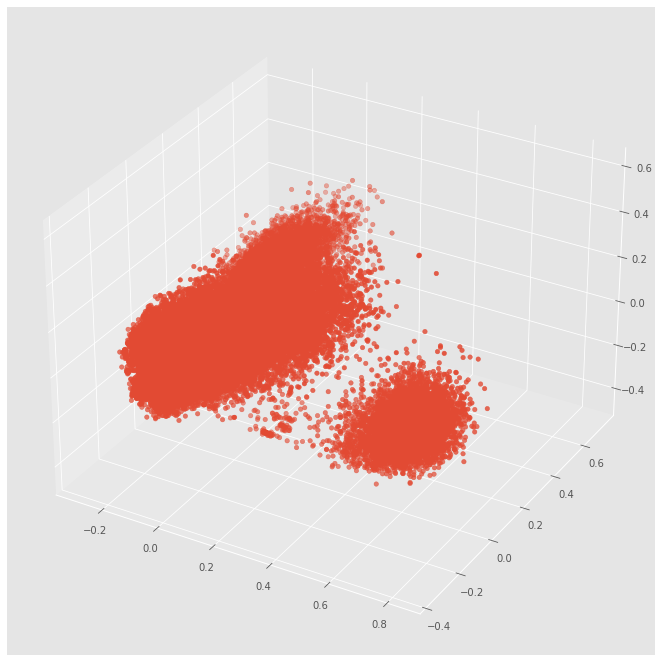

In [5]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
princomp = np.array(principalDf)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(princomp[:,0], princomp[:,1], princomp[:,2])

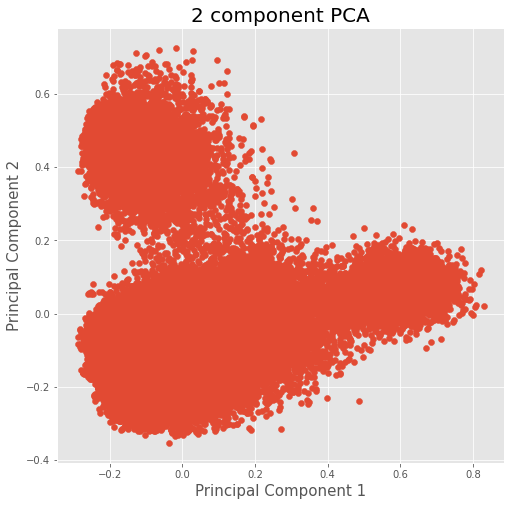

In [6]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(princomp[: ,0], princomp[: ,1])

We decided to use the algorithm MiniBatchKMeans as we found that the other algorithms were slow and didn't converged.

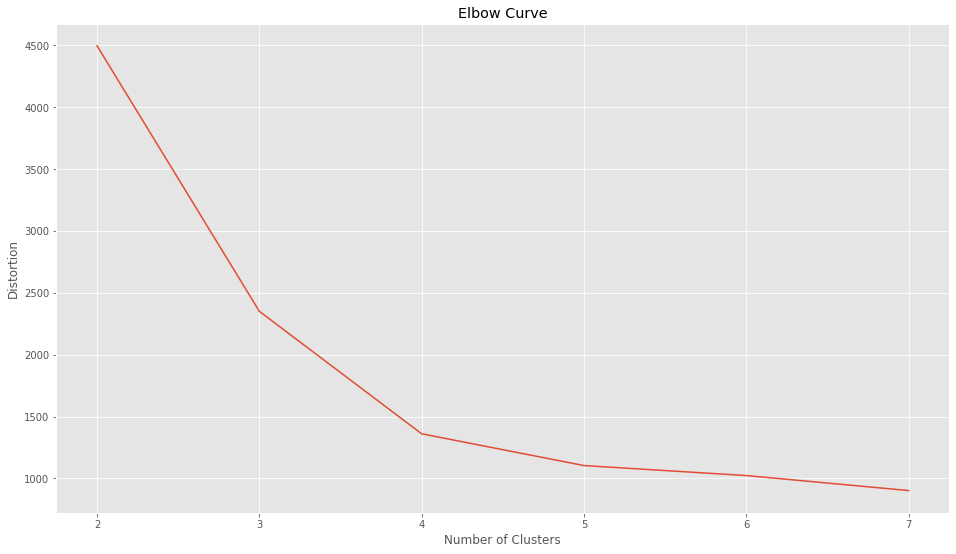

In [7]:
#Define the optimal k class
Nc = range(2, 8)
kmeans = [clt.MiniBatchKMeans(n_clusters=i, batch_size=1024) for i in Nc]
distortion = [kmeans[i].fit(princomp).inertia_ for i in range(len(kmeans))]
plt.plot(Nc,distortion)
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Curve')
plt.show()

We try first **THREE CLUSTERS K-MEANS**

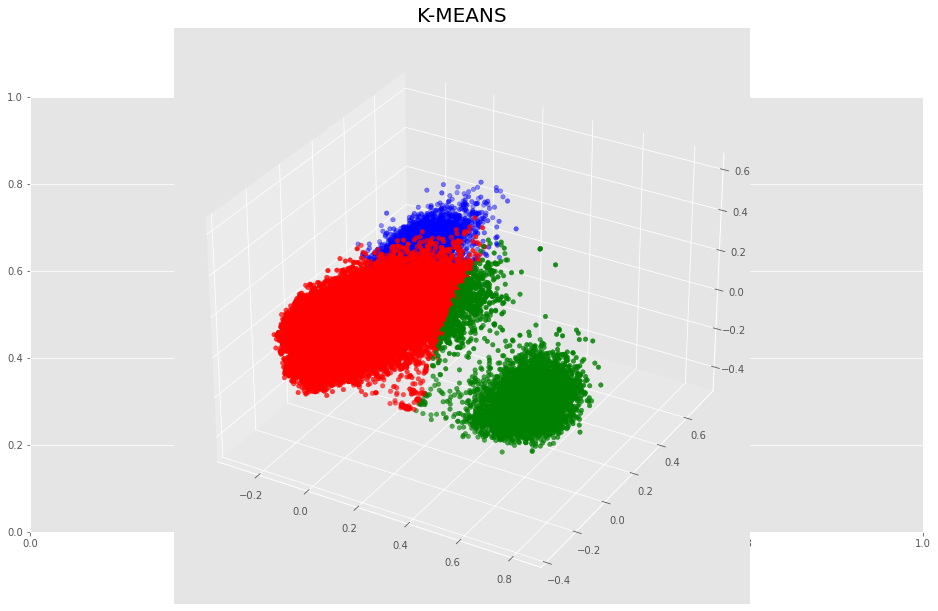

In [8]:
kmeans = clt.MiniBatchKMeans(n_clusters=3, random_state = 4).fit(princomp)
labels_k3 = kmeans.predict(princomp)

# Getting the cluster centers
C = kmeans.cluster_centers_
colors=['red','green','blue']
asign=[]

for row in labels_k3:
    asign.append(colors[row])

#plotting 3D clusters
fig, ax = plt.subplots(figsize = (16,8))
ax = Axes3D(fig)
ax.scatter(princomp[:, 0], princomp[:, 1], princomp[:,2], c=asign)
ax.set_title('K-MEANS', fontsize = 20)
plt.show()

Text(0.5, 1.0, 'CENTROIDS')

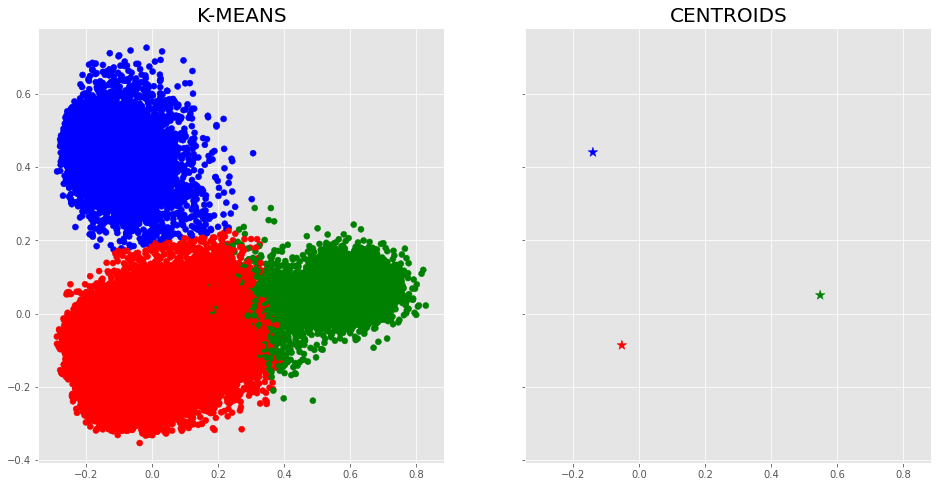

In [9]:
#plotting 2D clusters
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize = (16,8))
ax[0].scatter(princomp[:, 0], princomp[:, 1], c=asign)
ax[0].set_title('K-MEANS', fontsize = 20)
ax[1].scatter(C[:, 0], C[:, 1], c=colors, marker = "*", s = 100)
ax[1].set_title('CENTROIDS', fontsize = 20)

In [10]:
#Commit classification per author
k3_mean = pd.DataFrame()
k3_mean["AUTHOR"] = DB["AUTHOR"]
clusters= pd.DataFrame({"Cluster": labels_k3})
clusters = clusters["Cluster"].map(str).str.get_dummies()
k3_mean = pd.concat([k3_mean, clusters], axis = 1)
k3_mean = k3_mean.groupby(["AUTHOR"], as_index = False).agg("sum")
k3_mean.loc[len(k3_mean)] = ["Total", sum(k3_mean['0']), sum(k3_mean['1']), sum(k3_mean['2'])]
k3_mean

AUTHOR      0     1     2
0         Adrian Crum      5     1     2
1       Adrian Nistor      1     0     0
2          Alan Gates     58     9    10
3       Alex Karasulu     35     8     4
4    Alexander Shraer      7     3     1
..                ...    ...   ...   ...
353             dlaha      2     0     0
354              ecki      2     0     2
355             markt      0     1     0
356             pjack     32     4     3
357             Total  48035  6067  8815

[358 rows x 4 columns]

In [11]:
#Classificate authors in its maximum cluster
k3 = k3_mean.to_numpy()
author_cluster_k3 = []
author_cluster_k3 = pd.DataFrame()
author_cluster_k3["AUTHOR"] = k3[:, 0]
final_cluster = [np.argmax(k3[i,1:k3.shape[1]]) for i in range(k3.shape[0])]
author_cluster_k3["Final Cluster"] = final_cluster
author_cluster_k3
pd.pivot_table(author_cluster_k3, columns = "Final Cluster", aggfunc = "count")

Final Cluster    0  1   2
AUTHOR         341  6  11

Now **FOUR CLUSTERS K-MEANS**

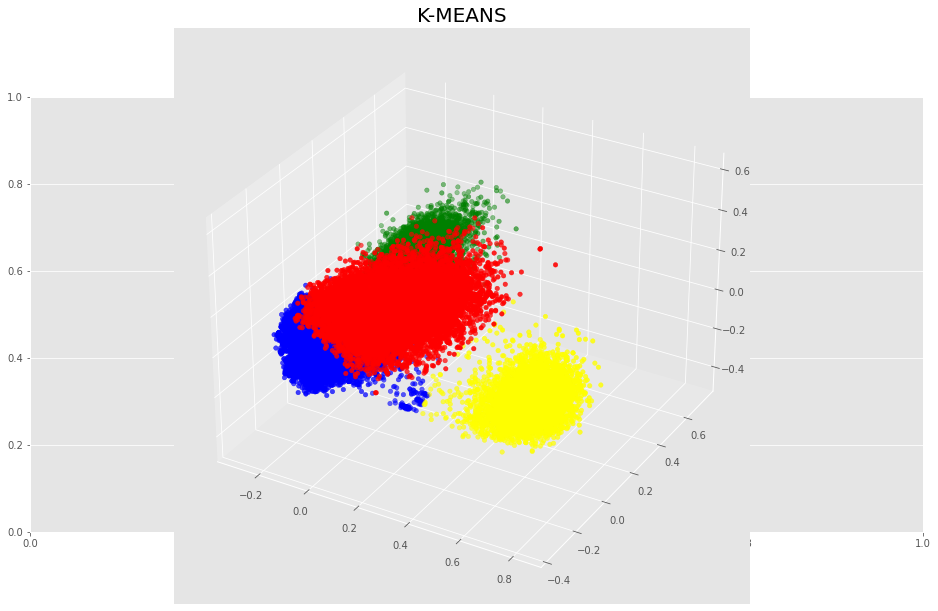

In [12]:
kmeans4 = clt.MiniBatchKMeans(n_clusters=4,random_state = 123).fit(princomp)
labels_k4 = kmeans4.predict(princomp)

# Getting the cluster centers
C = kmeans4.cluster_centers_
colors=['red','green','blue', 'yellow']
asign=[]

for row in labels_k4:
    asign.append(colors[row])

#Plotting 3D clusters
fig, ax = plt.subplots(figsize = (16,8))
ax = Axes3D(fig)
ax.scatter(princomp[:, 0], princomp[:, 1], princomp[:,2], c=asign)
ax.set_title('K-MEANS', fontsize = 20)
plt.show()

Text(0.5, 1.0, 'CENTROIDS')

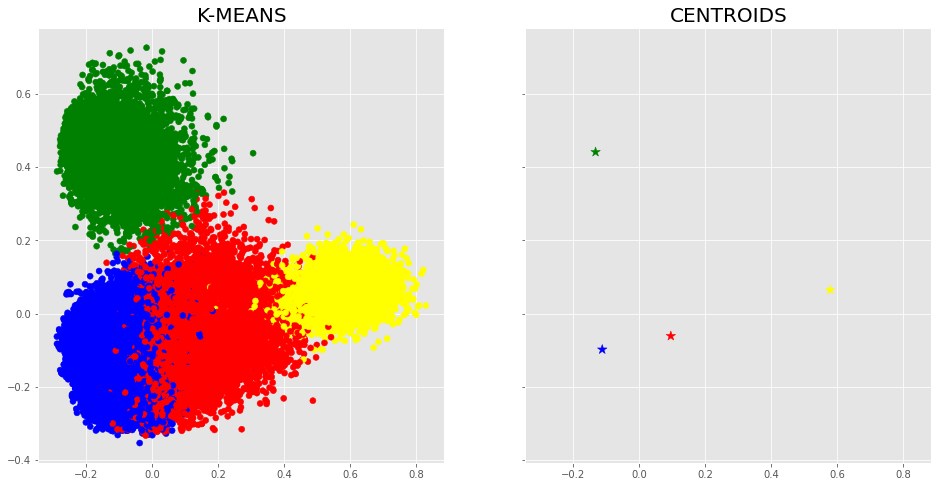

In [13]:
#Plotting 2D clusters
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize = (16,8))
ax[0].scatter(princomp[:, 0], princomp[:, 1], c=asign)
ax[0].set_title('K-MEANS', fontsize = 20)
ax[1].scatter(C[:, 0], C[:, 1], c=colors, marker = "*", s = 100)
ax[1].set_title('CENTROIDS', fontsize = 20)

In [14]:
#Commit classification per author
k4_mean = pd.DataFrame()
k4_mean["AUTHOR"] = DB["AUTHOR"]
clusters= pd.DataFrame({"Cluster": labels_k4})
clusters = clusters["Cluster"].map(str).str.get_dummies()
k4_mean = pd.concat([k4_mean, clusters], axis = 1)
k4_mean = k4_mean.groupby(["AUTHOR"], as_index= False).agg("sum")
k4_mean.loc[len(k4_mean)] = ["Total", sum(k4_mean['0']), sum(k4_mean['1']), sum(k4_mean['2']), sum(k4_mean['3'])]
k4_mean

AUTHOR      0     1      2     3
0         Adrian Crum      2     2      4     0
1       Adrian Nistor      0     0      1     0
2          Alan Gates     16    10     44     7
3       Alex Karasulu     12     4     23     8
4    Alexander Shraer      3     1      4     3
..                ...    ...   ...    ...   ...
353             dlaha      1     0      1     0
354              ecki      1     2      1     0
355             markt      1     0      0     0
356             pjack     11     3     22     3
357             Total  16481  8731  32179  5526

[358 rows x 5 columns]

In [15]:
#Classificate authors in its maximum cluster
k4 = k4_mean.to_numpy()
author_cluster_k4 = pd.DataFrame()
author_cluster_k4["AUTHOR"] = k4[:, 0]
final_cluster = [np.argmax(k4[i,1:k4.shape[1]]) for i in range(k4.shape[0])]
author_cluster_k4["Final Cluster"] = final_cluster
author_cluster_k4
pd.pivot_table(author_cluster_k4, columns = "Final Cluster", aggfunc = "count")

Final Cluster   0   1    2  3
AUTHOR         42  18  296  2

**Evaluation and comparison**

In [16]:
from sklearn import metrics
#Calinski-Harabasz Index

CH_k3 = metrics.calinski_harabasz_score(X, labels_k3)
CH_k4 = metrics.calinski_harabasz_score(X, labels_k4)

print("Calinski-Harabasz Index para K = 3:", CH_k3)
print("Calinski-Harabasz Index para K = 4:", CH_k4)

Calinski-Harabasz Index para K = 3: 4868.7713324044
Calinski-Harabasz Index para K = 4: 4121.335496493273


In [17]:
#Davies-Bouldin Index

DB_k3 = metrics.davies_bouldin_score(X, labels_k3)
DB_k4 = metrics.davies_bouldin_score(X, labels_k4)

print("Davies-Bouldin Index para K = 3:", DB_k3)
print("Davies-Bouldin Index para K = 4:", DB_k4)

Davies-Bouldin Index para K = 3: 2.2213161661453333
Davies-Bouldin Index para K = 4: 3.4805419020553927


As the Calinski-Harabasz is higher in the K=3 (which is good) and the Davies-Bouldin Index is smaller for K=3 (also good) we pick
**THREE CLUSTERS** to perform analysis.

## **3.-Project-Cluster Relation**

In [18]:
#Percentaje of authors per project in each project
k3_pj = pd.DataFrame()
k3_pj["PROJECT_ID"] = DB["PROJECT_ID"].copy()
clusters= pd.DataFrame({"Cluster": labels_k3})
clusters = clusters["Cluster"].map(str).str.get_dummies()
k3_pj = pd.concat([k3_pj, clusters], axis = 1)
k3_pj = k3_pj.groupby(["PROJECT_ID"], as_index = False).agg("sum")
k3_pj["tot"] = k3_pj["0"] +  k3_pj["1"] +  k3_pj["2"]
k3_pj["p0"] =  k3_pj["0"] / k3_pj["tot"]
k3_pj["p1"] = k3_pj["1"] / k3_pj["tot"]
k3_pj["p2"] = k3_pj["2"] / k3_pj["tot"]
k3_pj

PROJECT_ID     0    1     2   tot        p0        p1  \
0              org.apache:archiva  3571  442   652  4665  0.765488  0.094748   
1                org.apache:batik  1329  181   239  1749  0.759863  0.103488   
2                 org.apache:bcel   992  126   204  1322  0.750378  0.095310   
3            org.apache:beanutils   911  101   197  1209  0.753515  0.083540   
4              org.apache:cayenne   949  117   175  1241  0.764706  0.094279   
5               org.apache:cocoon  6865  862  1195  8922  0.769446  0.096615   
6                org.apache:codec  1332  169   227  1728  0.770833  0.097801   
7          org.apache:collections  2105  254   402  2761  0.762405  0.091996   
8          org.apache:commons-cli   647   71   119   837  0.772999  0.084827   
9         org.apache:commons-exec   475   58    81   614  0.773616  0.094463   
10  org.apache:commons-fileupload   651   92   119   862  0.755220  0.106729   
11          org.apache:commons-io  1427  192   285  1904  0.749475  0.100840   
12       org.apache:commons-jelly  1501  166   269  1936  0.775310  0.085744   
13        org.apache:commons-jexl  1157  154   218  1529  0.756704  0.100719   
14       org.apache:configuration  2243  274   411  2928  0.766052  0.093579   
15              org.apache:daemon   734   95   150   979  0.749745  0.097038   
16                org.apache:dbcp  1177  138   233  1548  0.760336  0.089147   
17             org.apache:dbutils   435   62   104   601  0.723794  0.103161   
18            org.apache:digester  1605  208   325  2138  0.750702  0.097287   
19               org.apache:felix  2146  282   410  2838  0.756166  0.099366   
20                org.apache:hive  4369  549   739  5657  0.772317  0.097048   
21          org.apache:httpclient  2105  254   351  2710  0.776753  0.093727   
22            org.apache:httpcore  1436  190   271  1897  0.756985  0.100158   
23              org.apache:jxpath   448   63    84   595  0.752941  0.105882   
24                 org.apache:net  1591  206   284  2081  0.764536  0.098991   
25                org.apache:ognl   440   71    94   605  0.727273  0.117355   
26           org.apache:santuario  1171  149   210  1530  0.765359  0.097386   
27              org.apache:thrift  1442  197   262  1901  0.758548  0.103630   
28           org.apache:validator  1034  117   186  1337  0.773373  0.087509   
29                 org.apache:vfs  1595  195   288  2078  0.767565  0.093840   
30           org.apache:zookeeper   152   32    31   215  0.706977  0.148837   

          p2  
0   0.139764  
1   0.136650  
2   0.154312  
3   0.162945  
4   0.141015  
5   0.133939  
6   0.131366  
7   0.145599  
8   0.142174  
9   0.131922  
10  0.138051  
11  0.149685  
12  0.138946  
13  0.142577  
14  0.140369  
15  0.153218  
16  0.150517  
17  0.173045  
18  0.152011  
19  0.144468  
20  0.130635  
21  0.129520  
22  0.142857  
23  0.141176  
24  0.136473  
25  0.155372  
26  0.137255  
27  0.137822  
28  0.139117  
29  0.138595  
30  0.144186

We observe that the proportions of cluster entries per project are the same as the ones obtained with all the entries of all project! Which means that no differentiation between projects in our embeddings!

## **4.-Author-Cluster Relation**

Each author has been assigned by majority to a cluster, lets check entries to see if we can find some characteristics!

In [19]:
pd.pivot_table(author_cluster_k3, columns = "Final Cluster", aggfunc = "count")

Final Cluster    0  1   2
AUTHOR         341  6  11

In [20]:
authors0 = author_cluster_k3[author_cluster_k3["Final Cluster"] == 0] 
authors1 = author_cluster_k3[author_cluster_k3["Final Cluster"] == 1] 
authors2 = author_cluster_k3[author_cluster_k3["Final Cluster"] == 2] 
print(len(authors0))
print(len(authors1))
print(len(authors2))

341
6
11


In [21]:
#for the authors of the cluster0
authors0_commits = DB[DB["AUTHOR"].isin(authors0["AUTHOR"])]
a_0 = authors0_commits.sample(n=10, random_state= 1234)
for i in range(10):
    print(a_0.iloc[i]["COMMIT_MESSAGE"])
    print()

Small javadoc fix.  git-svn-id: https://svn.apache.org/repos/asf/commons/proper/collections/trunk@1366166 13f79535-47bb-0310-9956-ffa450edef68

testcase for Bugzilla Bug 24136 ClassCastException in DriverAdapterCPDS when setPoolPreparedStatements(true) => currently failing   git-svn-id: https://svn.apache.org/repos/asf/jakarta/commons/proper/dbcp/trunk@132093 13f79535-47bb-0310-9956-ffa450edef68

Cleanup status file   git-svn-id: https://svn.apache.org/repos/asf/cocoon/trunk@27313 13f79535-47bb-0310-9956-ffa450edef68

Fix generics warnings  git-svn-id: https://svn.apache.org/repos/asf/commons/proper/bcel/trunk@1302520 13f79535-47bb-0310-9956-ffa450edef68

Ignore velocity logs  git-svn-id: https://svn.apache.org/repos/asf/jakarta/commons/proper/daemon/trunk@409874 13f79535-47bb-0310-9956-ffa450edef68

Remove junit dependencies. Silly me.  git-svn-id: https://svn.apache.org/repos/asf/xml/security/trunk@431350 13f79535-47bb-0310-9956-ffa450edef68

Stretch the bitmap on screen resolutions 

In [22]:
authors1_commits = DB[DB["AUTHOR"].isin(authors1["AUTHOR"])]
a_1 = authors1_commits.sample(n=10, random_state =1234)
for i in range(10):
    print(a_1.iloc[i]["COMMIT_MESSAGE"])
    print()
DB[DB["AUTHOR"].isin(authors1["AUTHOR"])]

Add no-arg constructor to test JDBC drivers. DBCP now requires this.

Added StripNameSpaceTransformer  git-svn-id: https://svn.apache.org/repos/asf/cocoon/trunk@492134 13f79535-47bb-0310-9956-ffa450edef68

OGNL-2 Updated source headers to all files.  git-svn-id: https://svn.apache.org/repos/asf/incubator/ognl/trunk@1102435 13f79535-47bb-0310-9956-ffa450edef68

Enabled plugin snapshot downloading.  git-svn-id: https://svn.apache.org/repos/asf/maven/repository-manager/trunk@410201 13f79535-47bb-0310-9956-ffa450edef68

Changed dependency from snapshot to release version  git-svn-id: https://svn.apache.org/repos/asf/maven/repository-manager/trunk@410196 13f79535-47bb-0310-9956-ffa450edef68

Changed the m2 repository URL    git-svn-id: https://svn.apache.org/repos/asf/incubator/felix/trunk@430198 13f79535-47bb-0310-9956-ffa450edef68

Test if arrays are sorted

+= isLegalFile(CharSequence)

Add test of illegal replacement char

Missing keyword Id while committed  git-svn-id: https://svn.apac

Unnamed: 0             PROJECT_ID  \
253           257     org.apache:archiva   
254           258     org.apache:archiva   
18918       45758      org.apache:cocoon   
18919       45759      org.apache:cocoon   
27811       62631  org.apache:commons-io   
27812       62632  org.apache:commons-io   
27813       62633  org.apache:commons-io   
36733       74074        org.apache:dbcp   
39902       78374       org.apache:felix   
55277      134162        org.apache:ognl   

                                    COMMIT_HASH  \
253    005800c3403199937c105999523a0225bd73a1f1   
254    cf102ca5ba9a9e8f3700b4ecaf4c21af159ee963   
18918  351cf54a565f1b480a3f648a82eb1ed96b73898f   
18919  dcaf74da53e6b33b5fc7cdf4fb33810ce9c9f784   
27811  dcf6e82f8610b89075e00711e186792053928c7e   
27812  84a0d90783b095775b5d14b2a807497862d80db5   
27813  10c8db1b1ae0fd9be8b661dbf24643c0a9012d68   
36733  d8dd39b32bbb04a28ea86eb826c56aa6783f3faf   
39902  e8c786eb92ed03bedc66ce1c6818d9876c01a179   
55277  b08b8197a3a4c07f75467bdcaddcf2f2035ebf77   

                                          COMMIT_MESSAGE  \
253    Changed dependency from snapshot to release ve...   
254    Enabled plugin snapshot downloading.  git-svn-...   
18918  Added StripNameSpaceTransformer  git-svn-id: h...   
18919  Missing keyword Id while committed  git-svn-id...   
27811                          Test if arrays are sorted   
27812                       += isLegalFile(CharSequence)   
27813               Add test of illegal replacement char   
36733  Add no-arg constructor to test JDBC drivers. D...   
39902  Changed the m2 repository URL    git-svn-id: h...   
55277  OGNL-2 Updated source headers to all files.  g...   

                        AUTHOR             COMMITTER_DATE  inc_complexity  \
253    Ernesto S. Tolentino Jr  2006-05-30 06:38:12+00:00             0.0   
254    Ernesto S. Tolentino Jr  2006-05-30 07:09:00+00:00             0.0   
18918           Ard Schrijvers  2007-01-03 13:21:06+00:00             7.0   
18919           Ard Schrijvers  2007-01-03 13:40:16+00:00             0.0   
27811                     Sebb  2017-11-16 12:20:32+00:00             3.0   
27812                     Sebb  2017-11-16 12:44:10+00:00             8.0   
27813                     Sebb  2017-11-16 15:33:58+00:00             3.0   
36733                    markt  2017-12-18 11:10:18+00:00             2.0   
39902              Trustin Lee  2006-08-10 00:46:12+00:00             0.0   
55277         Antonio Petrelli  2011-05-12 19:25:49+00:00             0.0   

       inc_violations  inc_development_cost  
253               0.0                   0.0  
254               0.0                  90.0  
18918             3.0                1230.0  
18919             0.0                   0.0  
27811            -2.0                 180.0  
27812             0.0                 600.0  
27813             1.0                 300.0  
36733             0.0                 120.0  
39902             0.0                 810.0  
55277           -67.0                   0.0

In [23]:
authors2_commits = DB[DB["AUTHOR"].isin(authors2["AUTHOR"])]
a_2 = authors2_commits.sample(n=10, random_state=1234)
for i in range(10):
    print(a_2.iloc[i]["COMMIT_MESSAGE"])
    print()

Compile error with the Single Imports.  Fixed.   git-svn-id: https://svn.apache.org/repos/asf/jakarta/bcel/trunk@152786 13f79535-47bb-0310-9956-ffa450edef68

HIVE-433. Fixed union18 and union19 tests. (athusoo via johan)  git-svn-id: https://svn.apache.org/repos/asf/hadoop/hive/trunk@768283 13f79535-47bb-0310-9956-ffa450edef68

Fixed:  Was using the SystemClassLoader when loading a class that is ignored by the ClassLoader.  Now  it uses deferTo.   git-svn-id: https://svn.apache.org/repos/asf/jakarta/bcel/trunk@152784 13f79535-47bb-0310-9956-ffa450edef68

HIVE-6594: UnsignedInt128 addition does not increase internal int array count resulting in corrupted values during serialization (Remus Rusanu reviewed by Jitendra Pandey)  git-svn-id: https://svn.apache.org/repos/asf/hive/trunk@1576317 13f79535-47bb-0310-9956-ffa450edef68

HIVE-525. Fix Eclipse classpath by adding Hadoop test jar. (Prasad Chakka via johan)  git-svn-id: https://svn.apache.org/repos/asf/hadoop/hive/trunk@780606 13f79535

## **5.-Metrics-Cluster Relation**

In this section we will try to find relations with metrics and the clusters

In [24]:
k3_metrics = pd.DataFrame()
k3_metrics[["inc_complexity", "inc_violations", "inc_development_cost"]] = DB[["inc_complexity", "inc_violations", "inc_development_cost"]].copy()
clusters= pd.DataFrame({"Cluster": labels_k3})
k3_metrics = pd.concat([k3_metrics, clusters], axis = 1)
k3_metrics0 = k3_metrics[k3_metrics["Cluster"] == 0]
k3_metrics1 = k3_metrics[k3_metrics["Cluster"] == 1]
k3_metrics2 = k3_metrics[k3_metrics["Cluster"] == 2]
k3_metrics["Cluster"] = k3_metrics["Cluster"].map(str)

In [25]:
print("cluster 0 \n", "average \n", k3_metrics0.mean(),"variança \n",k3_metrics0.var())

cluster 0 
 average 
 inc_complexity             4.598501
inc_violations             2.300260
inc_development_cost    1016.481940
Cluster                    0.000000
dtype: float64 variança 
 inc_complexity          2.492520e+05
inc_violations          3.124388e+04
inc_development_cost    5.943911e+09
Cluster                 0.000000e+00
dtype: float64


In [26]:
print("cluster 1 \n", "average \n", k3_metrics1.mean(),"variança \n",k3_metrics1.var())

cluster 1 
 average 
 inc_complexity            3.539641
inc_violations            0.568980
inc_development_cost    404.423933
Cluster                   1.000000
dtype: float64 variança 
 inc_complexity          3.325756e+05
inc_violations          2.953038e+04
inc_development_cost    6.785693e+09
Cluster                 0.000000e+00
dtype: float64


In [27]:
print("cluster 2 \n", "average \n",k3_metrics2.mean(),"variança \n",k3_metrics2.var())

cluster 2 
 average 
 inc_complexity            2.950199
inc_violations            0.921271
inc_development_cost    169.545094
Cluster                   2.000000
dtype: float64 variança 
 inc_complexity          2.561680e+05
inc_violations          3.195507e+04
inc_development_cost    5.800025e+09
Cluster                 0.000000e+00
dtype: float64


In [28]:
#fig = px.box(k3_metrics, x="Cluster", y="inc_complexity", points = "all")
#fig.show()

In [29]:
#fig = px.box(k3_metrics, x="Cluster", y="inc_violations", points = "all")
#fig.show()

In [30]:
#fig = px.box(k3_metrics, x="Cluster", y="inc_development_cost", points = "all")
#fig.show()

The plots are shown in the report as the number of entries causes the notebook to crash.

## **6.-Cluster Characteristics**

In [31]:
DB_subj = DB.copy()
DB_subj["labels"] = labels_k3
d_0 = DB_subj[DB_subj["labels"] == 0]
d_1 = DB_subj[DB_subj["labels"] == 1]
d_2 = DB_subj[DB_subj["labels"] == 2]

In [32]:
d_0s = d_0.sample(n=10, random_state=1234)
for i in range(10):
    print(d_0s.iloc[i]["COMMIT_MESSAGE"])
    print()

THRIFT-1342 Compilation problem on Windows of fastbinary.c Patch: alexandre parenteau  git-svn-id: https://svn.apache.org/repos/asf/thrift/trunk@1170180 13f79535-47bb-0310-9956-ffa450edef68

[VFS-437][FTP] StackOverFlowError getting the type of a directory with a symbolic link to a parent directory with the same name.  git-svn-id: https://svn.apache.org/repos/asf/commons/proper/vfs/trunk@1395004 13f79535-47bb-0310-9956-ffa450edef68

THRIFT-503. Use our standard include style in a few tests  git-svn-id: https://svn.apache.org/repos/asf/incubator/thrift/trunk@991245 13f79535-47bb-0310-9956-ffa450edef68

use html entity to prevent encoding issue  git-svn-id: https://svn.apache.org/repos/asf/archiva/trunk@1232210 13f79535-47bb-0310-9956-ffa450edef68

set up branch for 2.0 work  git-svn-id: https://svn-us.apache.org/repos/asf/commons/proper/jexl/branches/2.0@586967 13f79535-47bb-0310-9956-ffa450edef68

Make AbstractAuthenticationHandler immutable by changing the List to unmodifiable  git-sv

In [33]:
d_1s = d_1.sample(n=10, random_state=1)
for i in range(10):
    print(d_1s.iloc[i]["COMMIT_MESSAGE"])
    print()

checkstyle  git-svn-id: https://svn-us.apache.org/repos/asf/commons/proper/jexl/branches/2.0@587017 13f79535-47bb-0310-9956-ffa450edef68

o Adding navigation.xml file and removing the API link as it is   generated by maven.   git-svn-id: https://svn.apache.org/repos/asf/jakarta/bcel/trunk@152827 13f79535-47bb-0310-9956-ffa450edef68

Minor improvements of ant build. Switch to maven central as default repository.  git-svn-id: https://svn.apache.org/repos/asf/commons/proper/configuration/trunk@721712 13f79535-47bb-0310-9956-ffa450edef68

RFC 7540: HTTP protocol processing for HTTP/2 stream multiplexer  git-svn-id: https://svn.apache.org/repos/asf/httpcomponents/httpcore/trunk@1762527 13f79535-47bb-0310-9956-ffa450edef68

HTTPCLIENT-975: committed patch for stale-while-revalidate from Michajlo Matijkiw (michajlo_matijkiw at comcast dot com). Stale-while-revalidate functionality is currently off by default until we can add bounding to the revalidation queue (or make it configurable).  git-s

In [34]:
d_2s = d_2.sample(n=10, random_state=12)
for i in range(10):
    print(d_2s.iloc[i]["COMMIT_MESSAGE"])
    print()

Add license and notice  file to the online-manipulator Add apache license header to the online-manipulator  Edit license and notice file of junit4osgi  Add the online-manipulator to the reactor  Fix a potential NPE in the manipulator when the Created-By entry does not exist in the manipulated jar  git-svn-id: https://svn.apache.org/repos/asf/felix/trunk@767443 13f79535-47bb-0310-9956-ffa450edef68

Stop validating the sitemap.xmap files until we find a better way.   git-svn-id: https://svn.apache.org/repos/asf/cocoon/trunk@24361 13f79535-47bb-0310-9956-ffa450edef68

Did I woke up today? Re-adding bugfix that I nuked by reverting.   git-svn-id: https://svn.apache.org/repos/asf/cocoon/trunk@24722 13f79535-47bb-0310-9956-ffa450edef68

HIVE-7159: For inner joins push a 'is not null predicate' to the join sources for every non nullSafe join condition (Harish Butani via Gunther Hagleitner)  git-svn-id: https://svn.apache.org/repos/asf/hive/trunk@1604935 13f79535-47bb-0310-9956-ffa450edef68

s